# Step 1: Load Data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from multiprocessing.dummy import Pool
from tqdm import tqdm
import ast

# === Setting the path (±200k bp CpGs around MALAT1 for demo) ===
base_dir = Path("CpGs_around_MALAT1")
csv_path = base_dir / "data/CpGs_around_MALAT1.csv"
methy_dir = base_dir / "data/methy_ratios"
chr_dir = base_dir / "data/chrs"
pos_dir = base_dir / "data/positions"
methy_token_dir = base_dir / "data/methy_input_ids"
unmethy_token_dir = base_dir / "data/unmethy_input_ids"

# === Get file_name list ===
df = pd.read_csv(csv_path)
df["celltype_abbr"] = df["celltype_name"].str[:2]

# === Single sample processing function ===
def process_one_file(index):
    file_name = df["file_name"][index]
    celltype = df["celltype_abbr"][index]
    actual_exp = df["actual"][index]
    try:
        methy = np.load(methy_dir / file_name)["data"]
        chrs = np.load(chr_dir / file_name)["data"]
        positions = np.load(pos_dir / file_name)["data"]
        methy_input_ids = np.load(methy_token_dir / file_name)["data"]
        unmethy_input_ids = np.load(unmethy_token_dir / file_name)["data"]
        return methy, chrs, positions, methy_input_ids, unmethy_input_ids, file_name, celltype, actual_exp
    except Exception as e:
        print(f"[ERROR] {file_name}: {e}")
        return None

# === Read all samples in parallel ===
methy_list = []
chrs_list = []
positions_list = []
methy_input_ids_list = []
unmethy_input_ids_list = []
file_names = []
celltypes = []
actual_exps = []

with Pool(32) as pool:
    for result in tqdm(pool.imap_unordered(process_one_file, range(len(df))), total=len(df), desc="Loading all data"):
        if result is not None:
            methy, chrs, positions, methy_input_ids, unmethy_input_ids, fname, celltype, actual_exp = result
            methy_list.append(methy)
            chrs_list.append(chrs)
            positions_list.append(positions)
            methy_input_ids_list.append(methy_input_ids)
            unmethy_input_ids_list.append(unmethy_input_ids)
            file_names.append(fname)
            celltypes.append(celltype)
            actual_exps.append(actual_exp)

# === Output check ===
print(f"✅ Loaded {len(methy_list)} samples.")
print(f"🔹 Example methy shape: {methy_list[0].shape}")
print(f"🔹 Example chrs shape: {chrs_list[0].shape}")
print(f"🔹 Example positions shape: {positions_list[0].shape}")
print(f"🔹 Example methy_input_ids shape: {methy_input_ids_list[0].shape}")
print(f"🔹 Example unmethy_input_ids shape: {unmethy_input_ids_list[0].shape}")
print(f"🔹 Example file name: {file_names[0]}")
print(f"🔹 Example celltype: {celltypes[0]}")
print(f"🔹 Example expression: {actual_exps[0]}")

Loading all data: 100%|██████████| 167/167 [00:00<00:00, 219.69it/s]

✅ Loaded 167 samples.
🔹 Example methy shape: (55572,)
🔹 Example chrs shape: (55572,)
🔹 Example positions shape: (55572,)
🔹 Example methy_input_ids shape: (55572,)
🔹 Example unmethy_input_ids shape: (55572,)
🔹 Example file name: GSM2697566_scTrioSeq2Met_CRC01_ML4_142.singleC.npz
🔹 Example celltype: ML
🔹 Example expression: 0.4205979406833648


# Step2: Load Model

In [2]:
import sys
import os
from transformers import AutoTokenizer
from pathlib import Path

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.dataset.scdnam_dataset import TokensRatiosDataset, scDNAm_collate_TokensRatios
from src.model.scdnam_gpt import scDNAmGPTForPredictscRNAseq

tokenizer = AutoTokenizer.from_pretrained(f"../src/tokenizers/scdnam_6mer", trust_remote_code=True)

# Initialize model
model = scDNAmGPTForPredictscRNAseq.from_pretrained(
    tokenizer=tokenizer,
    pretrained_model_name="CpGs_around_MALAT1/model",
    device="cuda:0",
    num_labels=1,
    attention_mechanism={
        "projection_dim": 128,
        "attention_num_heads": 8,
        "dropout_rate": 0.1
    }
)

# Move model to device
device = "cuda:0"
model.to(device)  
model.eval() 

------------------------------------------
Shape of lm_head.weight:  torch.Size([520, 128]) 
------------------------------------------
[Missing keys]:
  - lm_head.weight


scDNAmGPTForPredictscRNAseq(
  (backbone): scDNAmMixerModel(
    (embedding): Embedding(520, 128)
    (layers): ModuleList(
      (0-7): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=128, out_features=520, bias=False)
  (query_proj): Linear(in_features=128, out_features=128, bias=True)
  (key_proj): Linear(in_features=128, out_features=128, bias=True)
  (value_proj): Linear(in_features=128, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicall

# Step 3: Inference

In [4]:
import torch
import numpy as np
import pandas as pd

model.to(dtype=torch.float16, device=device)
base_tensor = torch.tensor(methy, dtype=torch.float16, device=device)
target_label_idx = 0

def get_model_prob(methy_tensor, sample):
    """Compute model prediction probability for a given methylation tensor."""
    with torch.no_grad(), torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        outputs = model(
            unmethy_input_ids=torch.tensor(unmethy_input_ids_list[sample], dtype=torch.long, device=device).unsqueeze(0),
            methy_input_ids=torch.tensor(methy_input_ids_list[sample], dtype=torch.long, device=device).unsqueeze(0),
            methy_ratios=methy_tensor.unsqueeze(0).to(dtype=torch.float16),
            labels=None,
            return_dict=True
        )
        return outputs["predicted_probs"][0][target_label_idx].item()

num_samples = len(methy_list)
predictions = []


for sample in tqdm(range(num_samples), desc="Analyzing Samples"):
    methy = methy_list[sample].copy()
    base_tensor = torch.tensor(methy, dtype=torch.float16, device=device)
    prediction = get_model_prob(base_tensor, sample)
    predictions.append(prediction)

df["predicted"] = predictions

Analyzing Samples: 100%|██████████| 167/167 [00:09<00:00, 18.05it/s]


/tmp/ipykernel_3180/778902407.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(celltype_order))


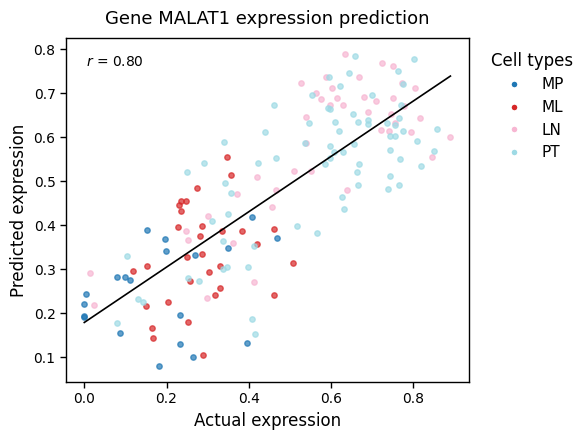

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import pearsonr
import matplotlib as mpl

# ======== Global plotting settings ========
mpl.rcParams.update({
    'font.size': 10,
    'axes.linewidth': 1,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'legend.frameon': False,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'pdf.fonttype': 42,  # embed text in PDF
    'ps.fonttype': 42
})

def set_dark_border(ax):
    """Add dark border around the axes"""
    for spine in ax.spines.values():
        spine.set_color("black")
        spine.set_linewidth(1.0)

# === Define cell type order (for consistent color & legend order) ===
celltype_order = ["MP", "ML", "LN", "PT"]

# === Define color map ===
cmap = cm.get_cmap('tab20', len(celltype_order))
color_map = {ct: cmap(i) for i, ct in enumerate(celltype_order)}

# === Compute Pearson correlation coefficient ===
r, _ = pearsonr(actual_exps, predictions)

# === Create figure ===
fig, ax = plt.subplots(figsize=(6, 4.5))

# === Scatter plot by cell type ===
for ct in celltype_order:
    mask = np.array(celltypes) == ct
    ax.scatter(
        np.array(actual_exps)[mask],
        np.array(predictions)[mask],
        s=15,
        alpha=0.7,
        color=color_map[ct],
        label=ct
    )

# === Global linear fit line ===
fit = np.polyfit(actual_exps, predictions, deg=1)
line_x = np.linspace(min(actual_exps), max(actual_exps), 100)
line_y = np.polyval(fit, line_x)
ax.plot(line_x, line_y, color='black', linewidth=1.2)

# === Display Pearson r value ===
ax.text(0.05, 0.95, f"$r$ = {r:.2f}", transform=ax.transAxes,
        fontsize=10, va='top')

# === Axis labels, title, and aesthetics ===
ax.set_xlabel("Actual expression", fontsize=12)
ax.set_ylabel("Predicted expression", fontsize=12)
ax.set_title("Gene MALAT1 expression prediction", fontsize=13, pad=10)
ax.tick_params(length=4, width=1)
ax.grid(False)

# === Legend (fixed order & color mapping) ===
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=ct,
               markerfacecolor=color_map[ct], markersize=5)
    for ct in celltype_order
]
ax.legend(handles=handles, title="Cell types",
          bbox_to_anchor=(1.02, 1), loc='upper left',
          title_fontsize=12, fontsize=11)

# === Apply dark border ===
set_dark_border(ax)
fig.tight_layout()

plt.show()
